In [208]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.1/173.1 kB 2.0 MB/s eta 0:00:002.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [228]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches # needed for waffle Charts
from PIL import Image # converting images into arrays
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
mpl.style.use('ggplot') # optional: for ggplot-like style

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/glensvenningsen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load Cook County Covid Mortality Data
csv_file_path = Path("data/pds.csv")
df_covid = pd.read_csv(csv_file_path)

# Convert the Index 'Date of Death' to datetime
df_covid['DATE_OF_DEATH'] = pd.to_datetime(df_covid['DATE_OF_DEATH'])
df_covid.set_index('DATE_OF_DEATH', inplace=True)

# Convert Age and Total Morbidities to Integer
df_covid['AGE'] = pd.to_numeric(df_covid['AGE'], errors='coerce').astype('Int64')
df_covid['TOTAL_MORBIDITIES'] = pd.to_numeric(df_covid['TOTAL_MORBIDITIES'], errors='coerce').astype('Int64')
df_covid.head()

,CASE_NUMBER,GENDER,AGE,RACE,LATINO,RESIDENCE_ZIP,MANNER_OF_DEATH,MORBIDITY,TOTAL_MORBIDITIES
DATE_OF_DEATH,,,,,,,,,
2020-04-03 08:36:00,ME2020-01945,Male,44,Black,False,NaN,NATURAL,ACUTE RESPIRATORY DISTRESS SYNDROME (ARDS),2
2020-04-03 08:36:00,ME2020-01945,Male,44,Black,False,NaN,NATURAL,COVID-19,2
2020-04-05 09:56:00,ME2020-02059,Male,68,Black,False,NaN,NATURAL,DIABETES MELLITUS,4
2020-04-05 09:56:00,ME2020-02059,Male,68,Black,False,NaN,NATURAL,COVID-19,4
2020-04-05 09:56:00,ME2020-02059,Male,68,Black,False,NaN,NATURAL,HYPOXEMIC RESPIRATORY FAILURE,4


In [200]:
# Count distinct CASE_NUMBER by Day
df_covid_count_by_day = df_covid.resample('D')['CASE_NUMBER'].nunique().reset_index()

# Count distinct CASE_NUMBER by Rolling 7 Days
df_covid_count_by_rolling_7_days = df_covid.resample('D')['CASE_NUMBER'].nunique().rolling(window=7).sum().reset_index()

# Count distinct CASE_NUMBER by Rolling 30 Days
df_covid_count_by_rolling_30_days = df_covid.resample('D')['CASE_NUMBER'].nunique().rolling(window=30).sum().reset_index()

# C
df_covid_count_by_rolling_7_days.head()

,DATE_OF_DEATH,CASE_NUMBER
0,2020-03-10,NaN
1,2020-03-11,NaN
2,2020-03-12,NaN
3,2020-03-13,NaN
4,2020-03-14,NaN


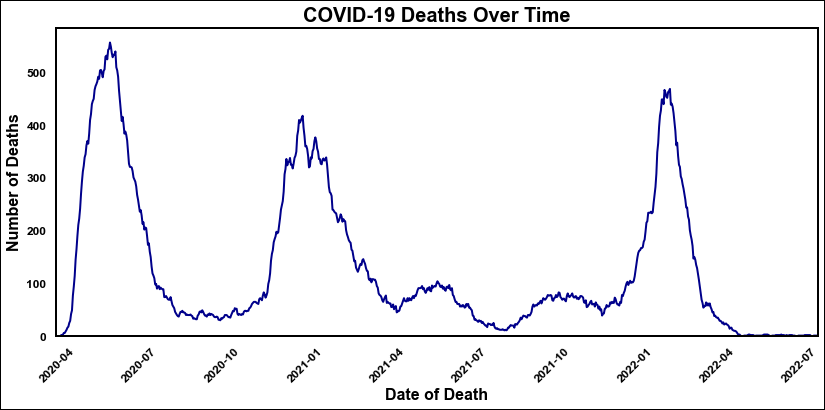

In [206]:
def min_max_dates(df):
    return df.index.min(), df.index.max()

def plot_covid_deaths(df):
    # Seaborn styling
    sns.set(style="whitegrid", palette="pastel")

    # Set a specific figure size
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Line plot with markers
    sns.lineplot(x='DATE_OF_DEATH', y='CASE_NUMBER', data=df, color='darkblue', linewidth=2, ax=ax)

    # Title and labels with adjusted font sizes
    plt.title('COVID-19 Deaths Over Time', fontsize=20, weight='bold', color='black')
    plt.xlabel('Date of Death', fontsize=16, weight='bold', color='black')
    plt.ylabel('Number of Deaths', fontsize=16, weight='bold', color='black')

    # Grid lines
    plt.grid(False)

    # X-axis rotation for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12, color='black', weight='bold')

    # Set x-axis limits to the specified date range
    start_date, end_date = df['DATE_OF_DEATH'].min(), pd.to_datetime('2022-07-01')
    plt.xlim(left=start_date, right=end_date)

    # Y-axis ticks with adjusted font size
    plt.yticks(fontsize=12, color='black', weight='bold')

    # Set y-axis lower limit to 0
    plt.ylim(bottom=0)

    # Add a darker border to the figure
    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(2)

    # Darken the outside border of the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

    # Use tight_layout with specified pad for spacing
    plt.tight_layout(pad=1.5)

    # Manually adjust the right margin by modifying the figure size
    fig.set_size_inches(12, 6)

    # Show the plot
    plt.show()


# Assuming df_covid_count_by_day is your DataFrame
# You can call the function with your DataFrame

plot_covid_deaths(df_covid_count_by_rolling_7_days)

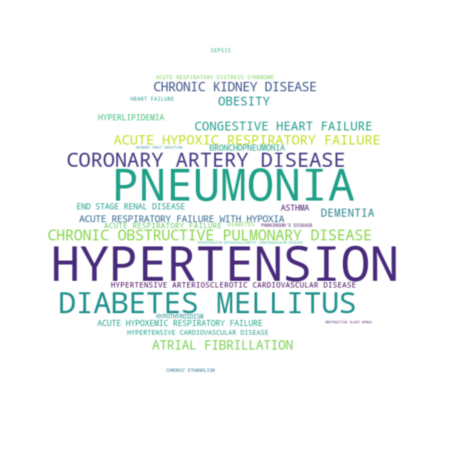

In [292]:
def wordcloud_covid(df):
    #save mask to covid_mask
    covid_mask = np.array(Image.open('data/Coronavirus-CDC-645x645.jpeg'))

    # Create a word cloud object with stopwords
    stopwords = set(STOPWORDS)
    stopwords.add('COVID-19')  # add the words 'COVID' to stopwords

    # instantiate a word cloud object
    covid_wc = WordCloud()

    # Drop create df of morbidities, drop nulls in column, and add a column of value_counts
    morbidity_counts_df = df['MORBIDITY'].dropna().value_counts().reset_index()

    # Rename the columns for clarity
    morbidity_counts_df.columns = ['MORBIDITY', 'MORBIDITY_COUNT']

    # Remove COVID-19
    morbidity_counts_df = morbidity_counts_df.iloc[1:]

    # Assuming 'MORBIDITY_CNT' is the column containing frequencies in your DataFrame
    morbidity_counts_df['MORBIDITY_COUNT'] = morbidity_counts_df['MORBIDITY_COUNT'].fillna(0)  # Replace NaN with 0

    # Generate word cloud based on the counts
    frequency_dict = morbidity_counts_df.set_index('MORBIDITY')['MORBIDITY_COUNT'].to_dict()

    # Generate word cloud based on the counts
    if sum(frequency_dict.values()) > 0:

        wordcloud = WordCloud(stopwords=stopwords, max_words=30, max_font_size=110, background_color='white', mask= covid_mask).generate_from_frequencies(frequency_dict)

        # Display the generated word cloud using matplotlib
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation="bicubic")
        plt.axis('off')
        plt.savefig('data/wordcloud_morbidities.png', bbox_inches='tight')
        plt.show()
    else:
        print("No valid frequencies to generate the word cloud.")
        
wordcloud_covid(df_covid)